# simulation for ecdfs field

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

import fitsio
import xlens
from astropy.table import Table

# =============================
# Matplotlib defaults
# =============================
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20
plt.rc("font", size=BIGGER_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)
plt.rc("axes", labelsize=BIGGER_SIZE)
plt.rc("xtick", labelsize=BIGGER_SIZE)
plt.rc("ytick", labelsize=BIGGER_SIZE)
plt.rc("legend", fontsize=BIGGER_SIZE)
plt.rc("figure", titlesize=BIGGER_SIZE)

In [2]:
pscratch= "/gpfs02/astro/workarea/xli6/"
Dir = os.path.join(
    pscratch,
    "work/DP1/"
)

In [17]:
data = Table.read(os.path.join(Dir, "catalogs", "anacal_catalog_ecdfs2.fits"))
sim = Table.read(os.path.join(Dir, "catalogs_sim", "anacal_catalog_ecdfs2.fits"))

In [18]:
sel1 = (
    ((31.4 - 2.5 * np.log10(data["i_flux_gauss2"])) < 24.5) &
    ((31.4 - 2.5 * np.log10(data["u_flux_gauss2"])) < 27.5) &
    ((31.4 - 2.5 * np.log10(data["g_flux_gauss2"])) < 26.0) &
    ((31.4 - 2.5 * np.log10(data["r_flux_gauss2"])) < 25.0) &
    ((31.4 - 2.5 * np.log10(data["z_flux_gauss2"])) < 25.) &
    ((31.4 - 2.5 * np.log10(data["y_flux_gauss2"])) < 25.) &
    ((data["i_fpfs1_m00"] + data["i_fpfs1_m20"]) / data["i_fpfs1_m00"] > 0.08)
)

sel2 = (
    ((31.4 - 2.5 * np.log10(sim["i_flux_gauss2"])) < 24.5) &
    ((31.4 - 2.5 * np.log10(sim["u_flux_gauss2"])) < 27.5) &
    ((31.4 - 2.5 * np.log10(sim["g_flux_gauss2"])) < 26.0) &
    ((31.4 - 2.5 * np.log10(sim["r_flux_gauss2"])) < 25.0) &
    ((31.4 - 2.5 * np.log10(sim["z_flux_gauss2"])) < 25.) &
    ((31.4 - 2.5 * np.log10(sim["y_flux_gauss2"])) < 25.) &
    ((sim["i_fpfs1_m00"] + sim["i_fpfs1_m20"]) / sim["i_fpfs1_m00"] > 0.08)
)

/tmp/ipykernel_2198297/4220716901.py:3: RuntimeWarning: invalid value encountered in log10
  ((31.4 - 2.5 * np.log10(data["u_flux_gauss2"])) < 27.5) &
/tmp/ipykernel_2198297/4220716901.py:4: RuntimeWarning: invalid value encountered in log10
  ((31.4 - 2.5 * np.log10(data["g_flux_gauss2"])) < 26.0) &
/tmp/ipykernel_2198297/4220716901.py:5: RuntimeWarning: invalid value encountered in log10
  ((31.4 - 2.5 * np.log10(data["r_flux_gauss2"])) < 25.0) &
/tmp/ipykernel_2198297/4220716901.py:6: RuntimeWarning: invalid value encountered in log10
  ((31.4 - 2.5 * np.log10(data["z_flux_gauss2"])) < 25.) &
/tmp/ipykernel_2198297/4220716901.py:7: RuntimeWarning: invalid value encountered in log10
  ((31.4 - 2.5 * np.log10(data["y_flux_gauss2"])) < 25.) &
/tmp/ipykernel_2198297/4220716901.py:13: RuntimeWarning: invalid value encountered in log10
  ((31.4 - 2.5 * np.log10(sim["u_flux_gauss2"])) < 27.5) &
/tmp/ipykernel_2198297/4220716901.py:14: RuntimeWarning: invalid value encountered in log10
  ((

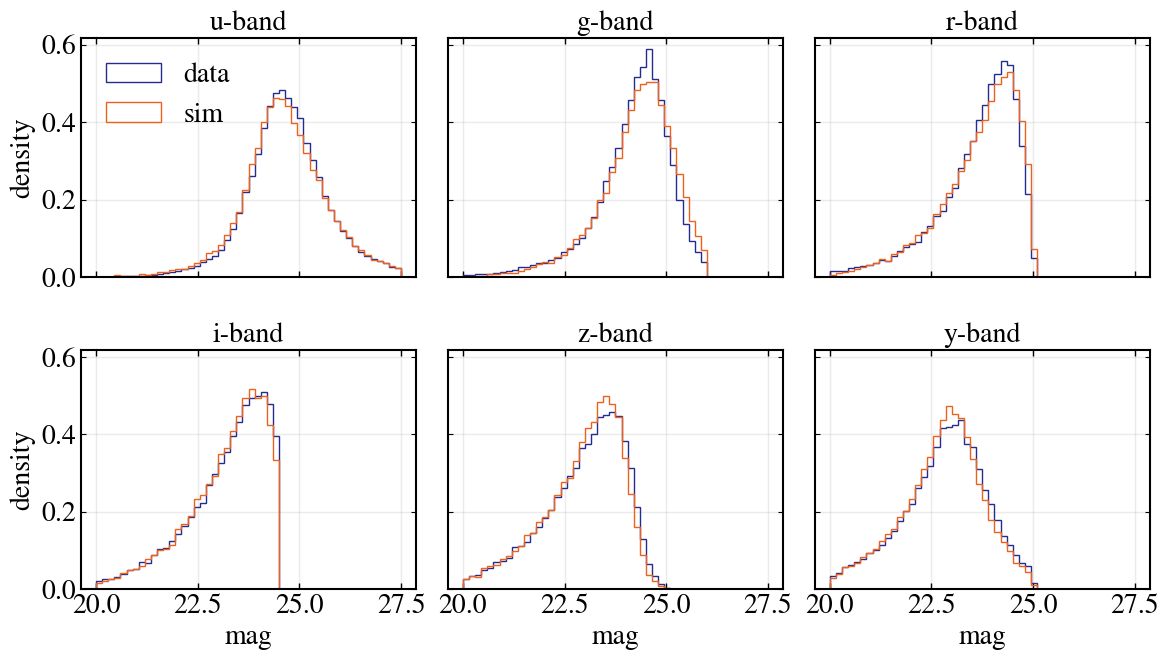

In [19]:
bands = "ugrizy"
mag_zero = 31.4
bins = 50
mag_range = (20, 27.5)

def flux_to_mag(flux, mag_zero=31.4):
    flux = np.asarray(flux)
    return mag_zero - 2.5 * np.log10(flux)

fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.ravel()

for i, b in enumerate(bands):
    ax = axes[i]

    f_data = np.asarray(data[f"{b}_flux_gauss2"])[sel1]
    f_sim  = np.asarray(sim[f"{b}_flux_gauss2"])[sel2]

    # guard against log10 problems
    m_data = np.isfinite(f_data) & (f_data > 0)
    m_sim  = np.isfinite(f_sim)  & (f_sim  > 0)

    mag_data = flux_to_mag(f_data[m_data], mag_zero=mag_zero)
    mag_sim  = flux_to_mag(f_sim[m_sim],   mag_zero=mag_zero)

    ax.hist(mag_data, histtype="step", bins=bins, density=True, range=mag_range, label="data")
    ax.hist(mag_sim,  histtype="step", bins=bins, density=True, range=mag_range, label="sim")

    ax.set_title(f"{b}-band")
    ax.grid(True, alpha=0.25)

    if i % 3 == 0:
        ax.set_ylabel("density")
    if i >= 3:
        ax.set_xlabel("mag")

# one shared legend for the whole figure
axes[0].legend(loc="upper left", frameon=False)

fig.tight_layout()
plt.show()

In [20]:
dd = {}
ss = {}
for b in "ugrizy":
    f_data = np.asarray(data[f"{b}_flux_gauss2"])[sel1]
    f_sim  = np.asarray(sim[f"{b}_flux_gauss2"])[sel2]

    dd[b] = mag_zero - 2.5 * np.log10(f_data)
    ss[b]  = mag_zero - 2.5 * np.log10(f_sim)

In [21]:
class corner_plot:
    def __init__(self, xrange, yrange, bins=30, xlabel="x", ylabel="y", xlim=None, ylim=None):
        fig = plt.figure(figsize=(8, 8))
        gs = fig.add_gridspec(4, 4, wspace=0.05, hspace=0.05)
        # 2D Contour plot (central plot)
        self.ax_2d = fig.add_subplot(gs[1:4, 0:3])
        self.ax_2d.set_xlabel(xlabel)
        self.ax_2d.set_ylabel(ylabel)
        
        self.ax_top = fig.add_subplot(gs[0, 0:3], sharex=self.ax_2d)
        self.ax_top.set_ylabel('PDF')
        self.ax_top.tick_params(axis="x", labelbottom=False)
        
        self.ax_right = fig.add_subplot(gs[1:4, 3], sharey=self.ax_2d)
        self.ax_right.set_xlabel('PDF')
        self.ax_right.tick_params(axis="y", labelleft=False)
        
        self.range_2d = [xrange, yrange]
        self.range_x = xrange
        self.range_y = yrange
        self.bins = bins

        if xlim is None:
            xlim = self.range_x
            
        if ylim is None:
            ylim = self.range_y
        self.ax_2d.set_xlim(xlim)
        self.ax_2d.set_ylim(ylim)
        self.ax_top.set_xlim(xlim)
        self.ax_right.set_ylim(ylim)
        return

    def make_plot(self, x_array, y_array, linestyles="-", levels=[0.1, 0.3, 0.6]):
        # Create figure and gridspec
        hist, xedges, yedges = np.histogram2d(
            x=x_array, y=y_array, bins=self.bins,
            range=self.range_2d,
            density=True,
        )
        # Calculate the midpoints of bins
        xcenters = 0.5 * (xedges[:-1] + xedges[1:])
        ycenters = 0.5 * (yedges[:-1] + yedges[1:])
        X, Y = np.meshgrid(xcenters, ycenters)
        
        # Contour plot
        contour = self.ax_2d.contour(
            X, Y, hist.T, levels=levels, 
            colors="black", linestyles=linestyles,
        )
        
        # 1D Histogram (top plot)
        self.ax_top.hist(x_array, bins=self.bins, histtype='step', color='black', 
            range=self.range_x, density=True, ls=linestyles,
        )
        
        # 1D Histogram (right plot)
        self.ax_right.hist(y_array, bins=self.bins, histtype='step', color='black', 
            range=self.range_y, density=True, 
            ls=linestyles, orientation='horizontal', 
        )
        
        # Final adjustments
        plt.tight_layout()
        

/tmp/ipykernel_2198297/3973144715.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


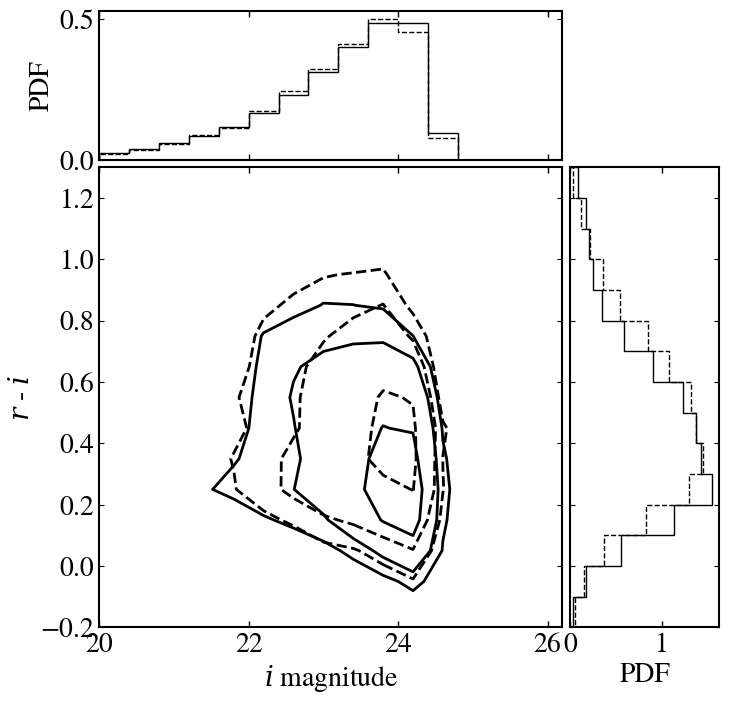

In [28]:
plt.close()
xrange = [20.0, 26.0]
yrange = [-0.2, 1.3]
xlabel = r'$i$ magnitude'
ylabel = r'$r$ - $i$'

corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=15, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.2, 1.3]
)


x_array = ss["i"]
y_array = ss["r"] - ss["i"]

x_array_d = dd["i"]
y_array_d = dd["r"] - dd["i"]

corp.make_plot(x_array=x_array_d, y_array=y_array_d, linestyles="-",  levels=[0.15, 0.3, 0.65])
corp.make_plot(x_array=x_array, y_array=y_array, linestyles="--",  levels=[0.15, 0.3, 0.65])

/tmp/ipykernel_2198297/3973144715.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


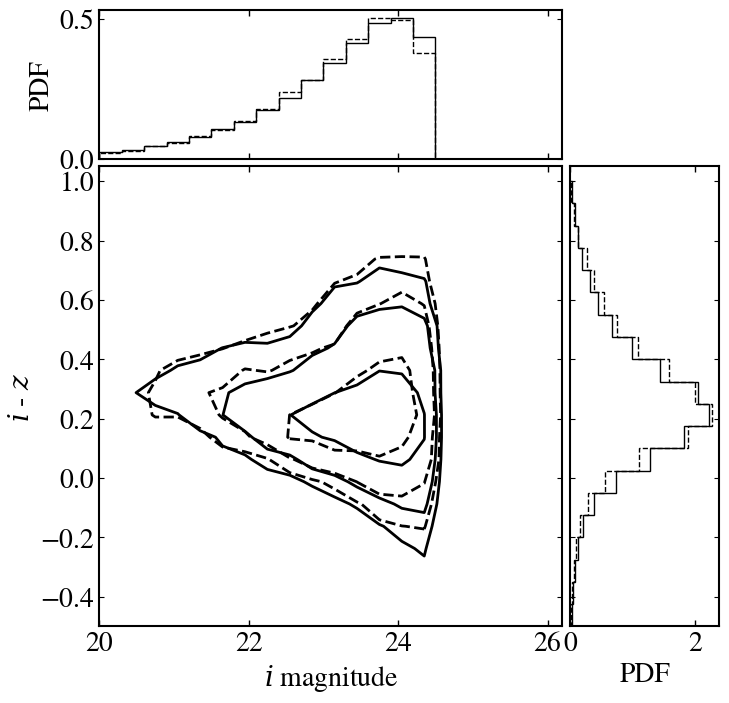

In [23]:
plt.close()

xrange = [20.0, 26.0]
yrange = [-0.5, 1.0]
xlabel = r'$i$ magnitude'
ylabel = r'$i$ - $z$'

corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=20, xlabel=xlabel, ylabel=ylabel,
    xlim=[20, 26.2], ylim=[-0.5, 1.05]
)

x_array = ss["i"]
y_array = ss["i"] - ss["z"]

x_array_d = dd["i"]
y_array_d = dd["i"] - dd["z"]

corp.make_plot(x_array=x_array_d, y_array=y_array_d, linestyles="-", levels=[0.15, 0.3, 0.65])
corp.make_plot(x_array=x_array, y_array=y_array, linestyles="--", levels=[0.15, 0.3, 0.65])

/tmp/ipykernel_2198297/3973144715.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


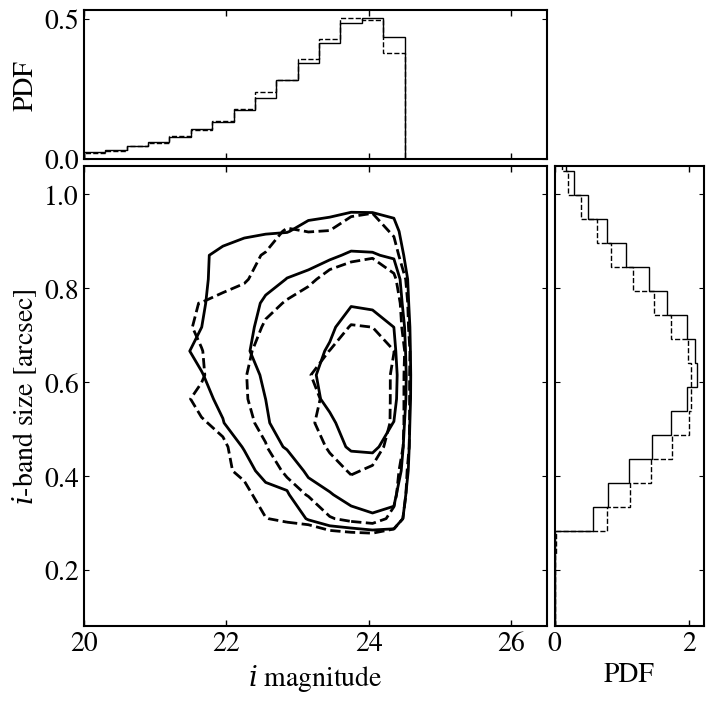

In [24]:
plt.close()

xrange = [20., 26]
yrange = [0.08, 1.1]
xlabel = r'$i$ magnitude'
ylabel = r'$i$-band size [arcsec]'
corp = corner_plot(
    xrange=xrange, yrange=yrange, bins=20, xlabel=xlabel, ylabel=ylabel,
    xlim=[20., 26.5], ylim=[0.08, 1.06]
)

x_array = ss["i"]
y_array = ((sim["i_fpfs1_m00"][sel2] + sim["i_fpfs1_m20"][sel2]) / sim["i_fpfs1_m00"][sel2]) ** 0.5

x_array_d = dd["i"]
y_array_d = ((data["i_fpfs1_m00"][sel1] + data["i_fpfs1_m20"][sel1]) / data["i_fpfs1_m00"][sel1]) ** 0.5

corp.make_plot(x_array=x_array_d, y_array=y_array_d, linestyles="-", levels=[0.2, 0.4, 0.8])
corp.make_plot(x_array=x_array, y_array=y_array, linestyles="--", levels=[0.2, 0.4, 0.8])

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2198297/869152246.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel(f"$\Delta$  Mag")


Text(0.5, 0, '$\\Delta$  Mag')

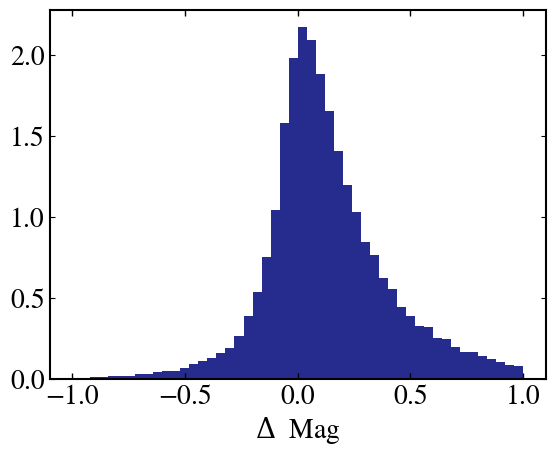

In [25]:
truth_fname = os.path.join("/gpfs02/astro/workarea/xli6//work/galaxy_input_catalog/catsim-v4/OneDegSq.fits")
truth_cat = Table.read(truth_fname)
truth_cat = truth_cat[sim["truth_index"]]

i_meas = 31.4 - 2.5 * np.log10(sim["i_flux_gauss2"])
i_truth = truth_cat["i_ab"]
_ = plt.hist(i_meas[sel2]-i_truth[sel2], bins=50, range=(-1, 1), density=True)
plt.xlabel(f"$\Delta$  Mag")

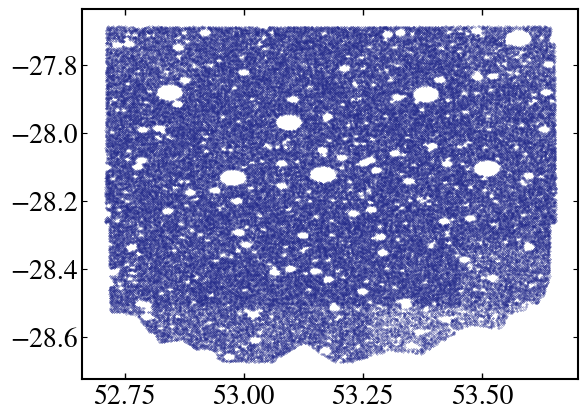

In [26]:
plt.scatter(sim["ra"], sim["dec"], s=0.05)

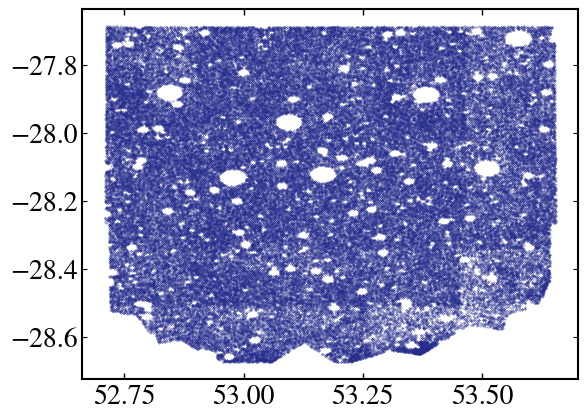

In [27]:
plt.scatter(data["ra"], data["dec"], s=0.05)

In [15]:
len(data)

129088

In [16]:
len(sim)

129152

In [172]:
a = Table.read("../../2025-11-21/tracts_fdfc_v1_final_sims.fits")
patch_db = a["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
pid = patch_x + patch_y * 9
a["patch_id"] = pid
a.write("../../2025-11-21/tracts_fdfc_v1_final_sims.fits", overwrite=True)